<a href="https://colab.research.google.com/github/keonju2/2022_BD/blob/main/using_kobert_news_kakao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

# torch
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#GPU 사용
device = torch.device("cuda:0")

#BERT 모델, Vocabulary 불러오기 필수
bertmodel, vocab = get_pytorch_kobert_model()


# KoBERT에 입력될 데이터셋 정리
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))  

# 모델 정의
class BERTClassifier(nn.Module): ## 클래스를 상속
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# Setting parameters
max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 100
learning_rate =  5e-5

## 학습 모델 로드
PATH = 'drive/MyDrive/colab/StoryFlower/bert/'
model = torch.load('/content/drive/MyDrive/BDL/kobert_kakao/KoBERT_kakao.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load('/content/drive/MyDrive/BDL/kobert_kakao/model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def new_softmax(a) : 
    c = np.max(a) # 최댓값
    exp_a = np.exp(a-c) # 각각의 원소에 최댓값을 뺀 값에 exp를 취한다. (이를 통해 overflow 방지)
    sum_exp_a = np.sum(exp_a)
    y = (exp_a / sum_exp_a) * 100
    return np.round(y, 3)


# 예측 모델 설정
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
            min_v = min(logits)
            total = 0
            probability = []
            logits = np.round(new_softmax(logits), 3).tolist()
            for logit in logits:
                print(logit)
                probability.append(np.round(logit, 3))

            if np.argmax(logits) == 0:  emotion = 0
            elif np.argmax(logits) == 1: emotion = 1

            probability.append(emotion)
            print(probability)
    return probability[2]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 12.7 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595733 sha256=61322e833226b3630537d9cad7f6720a69c9d791f09ccaed09d02b3d4e4cb986
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 15.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.p

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 6.4 MB 31.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
a = pd.read_csv('/content/drive/MyDrive/BDL/kakao_sentiment_data.csv', index_col = 0)

In [ ]:
sentiment = a.groupby(['일자'])['up_down'].mean()

In [ ]:
sentiment=pd.DataFrame(sentiment)

In [ ]:
sentiment.index = pd.to_datetime(sentiment.index)

In [ ]:
sentiment

,up_down
일자,
2017-07-01,0.0
2017-07-02,0.0
2017-07-03,0.0
2017-07-04,0.0
2017-07-05,1.0
...,...
2022-03-27,1.0
2022-03-28,1.0
2022-03-29,1.0


In [ ]:
train = yf.download('035720.KS',start = '2017-07-01',end='2022-03-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
train.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
test = yf.download('035720.KS',start = '2022-04-01',end='2022-04-30')

[*********************100%***********************]  1 of 1 completed


In [ ]:
train = pd.merge(train,sentiment,left_on =train.index,right_on=sentiment.index,how='left')

In [ ]:
train.rename(columns = {'key_0':'Date'},inplace = True)

In [ ]:
train=train.set_index('Date')
train

,Open,High,Low,Close,Adj Close,Volume,up_down
Date,,,,,,,
2017-07-03,20630.603516,20691.044922,19965.750000,20026.191406,19942.392578,2314802,0.0
2017-07-04,20126.925781,20247.808594,19744.132812,19804.574219,19721.703125,2166056,0.0
2017-07-05,19844.867188,20670.898438,19844.867188,20650.750000,20564.335938,2961457,1.0
2017-07-06,20811.927734,21335.751953,20791.779297,20973.103516,20885.341797,3511854,1.0
2017-07-07,20852.220703,20892.515625,20187.367188,20469.427734,20383.771484,4947596,0.0
...,...,...,...,...,...,...,...
2022-03-25,106779.492188,107786.843750,104764.781250,105772.132812,105772.132812,1929897,1.0
2022-03-28,105772.132812,106275.812500,103253.750000,105772.132812,105772.132812,1523156,1.0
2022-03-29,106779.492188,107283.164062,105268.460938,106275.812500,106275.812500,1309348,1.0


In [ ]:
sentiment_test = pd.read_csv('/content/drive/MyDrive/BDL/kakao_test.csv', index_col = 0)
sentiment_test

,일자,제목
0,2022-04-30,"카카오 공동체, 기후 위기 대응 원칙 수립 2040년까지 온실가스 배출량 ‘0’ 도전"
1,2022-04-30,청와대 사전관람 접수 100만 돌파 내달 10일 개방
2,2022-04-30,"<부고> 김성수 (카카오 부회장, 카카오엔터테인먼트 대표이사) 모친상"
3,2022-04-30,고급화는 어디로 광희의 ‘네고’ 대상이 된 명품? [명품톡+]
4,2022-04-30,[부고] 김성수 카카오 부회장 모친상
...,...,...
1886,2022-04-01,[고성]강원세계산림엑스포 성공 기원 나무 식재
1887,2022-04-01,직원 연봉 2억 시대 연봉킹은 게임 엔터
1888,2022-04-01,"아이폰 업데이트 했더니 “내 번호, 카카오택시에 그대로 노출”"
1889,2022-04-01,"롯데정보통신, 공공기관용 클라우드 서비스 제공"


In [ ]:
sentiment_test['result'] = sentiment_test['제목'].apply(predict)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
99.89700317382812
[0.103, 99.897, 1]
0.1550000011920929
99.84500122070312
[0.155, 99.845, 1]
21.756999969482422
78.24299621582031
[21.757, 78.243, 1]
99.927001953125
0.0729999989271164
[99.927, 0.073, 0]
0.0689999982714653
99.93099975585938
[0.069, 99.931, 1]
99.91999816894531
0.07999999821186066
[99.92, 0.08, 0]
0.34200000762939453
99.65799713134766
[0.342, 99.658, 1]
99.8239974975586
0.17599999904632568
[99.824, 0.176, 0]
1.628000020980835
98.37200164794922
[1.628, 98.372, 1]
71.78700256347656
28.21299934387207
[71.787, 28.213, 0]
83.45800018310547
16.54199981689453
[83.458, 16.542, 0]
0.47200000286102295
99.52799987792969
[0.472, 99.528, 1]
0.289000004529953
99.71099853515625
[0.289, 99.711, 1]
0.09700000286102295
99.90299987792969
[0.097, 99.903, 1]
0.32199999690055847
99.6780014038086
[0.322, 99.678, 1]
0.07800000160932541
99.9219970703125
[0.078, 99.922, 1]
0.0689999982714653
99.93099975585938
[0.069, 99.931, 1]
0.07199999690055847
99.928001403

In [ ]:
sentiment_test=sentiment_test[['일자','result']]

In [ ]:
sentiment_test = sentiment_test.groupby(['일자'])['result'].mean()

In [ ]:
sentiment_test=pd.DataFrame(sentiment_test)

In [ ]:
sentiment_test.index = pd.to_datetime(sentiment_test.index)

In [ ]:
sentiment_test

,result
일자,
2022-04-01,0.586957
2022-04-02,0.545455
2022-04-03,0.518519
2022-04-04,0.653465
2022-04-05,0.585366
2022-04-06,0.325203
2022-04-07,0.529412
2022-04-08,0.654545
2022-04-09,0.750000


<function matplotlib.pyplot.show>

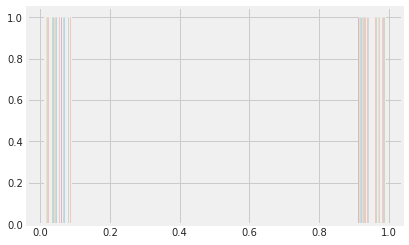

In [ ]:
plt.hist(sentiment)
plt.show

In [ ]:
test = pd.merge(test,sentiment_test,left_on =test.index,right_on=sentiment_test.index,how='left')

In [ ]:
test.rename(columns = {'key_0':'Date'},inplace = True)

In [ ]:
test=test.set_index('Date')
test

,Open,High,Low,Close,Adj Close,Volume,result
Date,,,,,,,
2022-04-01,106275.812500,107283.164062,105772.132812,106779.492188,106779.492188,1155308,0.586957
2022-04-04,106275.812500,106779.492188,104764.781250,106275.812500,106275.812500,1266934,0.653465
2022-04-05,107283.164062,108794.195312,106779.492188,108290.523438,108290.523438,1605853,0.585366
2022-04-06,106275.812500,107283.164062,104764.781250,105772.132812,105772.132812,1518450,0.325203
2022-04-07,103757.429688,104261.109375,100634.632812,100634.632812,100634.632812,2864778,0.529412
2022-04-08,100735.367188,101239.046875,97209.632812,98720.664062,98720.664062,2908402,0.654545
2022-04-11,97814.039062,97814.039062,95295.656250,95799.335938,95799.335938,2046173,0.673913
2022-04-12,94086.835938,95799.335938,92777.273438,94791.984375,94791.984375,1896003,0.630769
2022-04-13,95698.601562,96907.421875,95295.656250,96504.484375,96504.484375,1392995,0.666667


In [ ]:
X_train = train.drop(columns='Close')
y_train = train.iloc[:, 3:4]

X_test = test.drop(columns='Close')
y_test = test.iloc[:, 3:4]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
y_train = ss.fit_transform(y_train)


X_test = ss.fit_transform(X_test)
y_test = ss.fit_transform(y_test)


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([1163, 1, 6]) torch.Size([1163, 1])
Testing Shape torch.Size([21, 1, 6]) torch.Size([21, 1])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [ ]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

In [ ]:
num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 6 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

In [ ]:
epoch_list = []
loss_list = []

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))  
    epoch_list.append(epoch)
    loss_list.append(loss.item()) 

Epoch: 0, loss: 0.05135
Epoch: 100, loss: 0.05095
Epoch: 200, loss: 0.05057
Epoch: 300, loss: 0.05021
Epoch: 400, loss: 0.04986
Epoch: 500, loss: 0.04952
Epoch: 600, loss: 0.04911
Epoch: 700, loss: 0.04840
Epoch: 800, loss: 0.04758
Epoch: 900, loss: 0.04683
Epoch: 1000, loss: 0.04614
Epoch: 1100, loss: 0.04549
Epoch: 1200, loss: 0.04488
Epoch: 1300, loss: 0.04430
Epoch: 1400, loss: 0.04375
Epoch: 1500, loss: 0.04323
Epoch: 1600, loss: 0.04273
Epoch: 1700, loss: 0.04218
Epoch: 1800, loss: 0.04162
Epoch: 1900, loss: 0.04108
Epoch: 2000, loss: 0.04056
Epoch: 2100, loss: 0.04006
Epoch: 2200, loss: 0.03958
Epoch: 2300, loss: 0.03912
Epoch: 2400, loss: 0.03866
Epoch: 2500, loss: 0.03822
Epoch: 2600, loss: 0.03779
Epoch: 2700, loss: 0.03736
Epoch: 2800, loss: 0.03693
Epoch: 2900, loss: 0.03650
Epoch: 3000, loss: 0.03607
Epoch: 3100, loss: 0.03566
Epoch: 3200, loss: 0.03526
Epoch: 3300, loss: 0.03488
Epoch: 3400, loss: 0.03450
Epoch: 3500, loss: 0.03413
Epoch: 3600, loss: 0.03377
Epoch: 3700, 

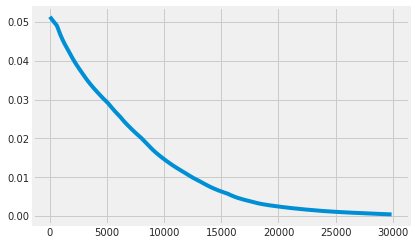

In [ ]:
r = pd.DataFrame(loss_list,index = epoch_list,columns=['Loss'])
plt.plot(r,label = 'Loss')

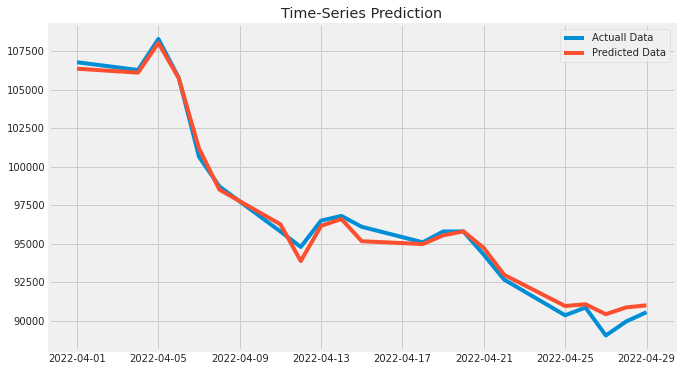

In [ ]:
test_predict = lstm1( X_test_tensors_final.to(device))#forward pass
data_predict = test_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = y_test_tensors.data.numpy()

data_predict = ss.inverse_transform(data_predict) #reverse transformation
dataY_plot = ss.inverse_transform(dataY_plot)

data_predict = pd.DataFrame(data_predict,index=test.index)
dataY_plot = pd.DataFrame(dataY_plot,index=test.index)

plt.figure(figsize=(10,6)) #plotting

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [ ]:
dataY_plot

,0
Date,
2022-04-01,106779.492188
2022-04-04,106275.812500
2022-04-05,108290.523438
2022-04-06,105772.132812
2022-04-07,100634.632812
2022-04-08,98720.664062
2022-04-11,95799.335938
2022-04-12,94791.984375
2022-04-13,96504.484375


In [ ]:
data_predict

,0
Date,
2022-04-01,106359.101562
2022-04-04,106106.132812
2022-04-05,108034.937500
2022-04-06,105743.320312
2022-04-07,101171.414062
2022-04-08,98514.156250
2022-04-11,96262.203125
2022-04-12,93880.328125
2022-04-13,96164.210938


In [ ]:
from sklearn.metrics import mean_absolute_error
import math, time


testScore = math.sqrt(mean_absolute_error(dataY_plot, data_predict))
print('Test Score: %.2f MAE' % (testScore))

Test Score: 20.87 MAE


In [ ]:
dataY_plot-data_predict

,0
Date,
2022-04-01,420.390625
2022-04-04,169.679688
2022-04-05,255.585938
2022-04-06,28.812500
2022-04-07,-536.781250
2022-04-08,206.507812
2022-04-11,-462.867188
2022-04-12,911.656250
2022-04-13,340.273438
